<a href="https://colab.research.google.com/github/MajedeR/mechanical-stress-prediction/blob/main/stress_prediction_6061.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive to use dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import libraries
import pandas as pd
import numpy as np
import zipfile
import os
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
###Uzip data (Just run once)
# zip_path = '/content/drive/MyDrive/stress_prediction_6061/unzipped_folder/Stress-strain data for aluminum 6061-T651 from 9 lots at 6 temperatures under uniaxial and plain strain tension/stress-strain-curves-of-aluminum-6061-t651-from-9-lots-at-6-temperatures-under-uniaxial-and-plain-strain-tension.zip'

# #extract dir
# extract_to = '/content/drive/MyDrive/stress_prediction_6061/Newunzipped_folder'
# os.makedirs(extract_to, exist_ok=True)


# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)


In [4]:
#Data folder direction
Data_dir = '/content/drive/MyDrive/stress_prediction_6061/Newunzipped_folder'

In [5]:
#make list for directions
file_names = os.listdir(Data_dir)
csv_paths = [os.path.join(Data_dir,i) for i in file_names]

print(f"Example Name:  {file_names[0]}")
print(f"Example Path:  {csv_paths[0]}")
print(f"Len Data: {len(csv_paths)}")

Example Name:  P_020_G_2_022_195_24.csv
Example Path:  /content/drive/MyDrive/stress_prediction_6061/Newunzipped_folder/P_020_G_2_022_195_24.csv
Len Data: 154


In [6]:
#Read csv files
data = [pd.read_csv(i) for i in csv_paths]

In [7]:
#Show the example data
example = data[0]
print(example)

        Strain  Stress_MPa
0    -0.000096    0.583252
1    -0.000099    0.591747
2    -0.000103    0.599371
3    -0.000105    0.606555
4    -0.000108    0.613481
...        ...         ...
1000  0.265238  230.688502
1001  0.265863  230.227235
1002  0.266486  229.756038
1003  0.267110  229.273017
1004  0.267111    0.000000

[1005 rows x 2 columns]


#Create DataFrame

In [8]:
dataset = []
for i in range(0, len(csv_paths)):


  datadf = data[i]


  #Get features from file names
  datadata = file_names[i].split("_")
  datatype = datadata[0]
  dataTemp = datadata[1]
  dataLot = datadata[2]
  dataNum = datadata[3]



  #Get mechanical properties from df
  datastrains = datadf.iloc[ : , 0]
  datastress = datadf.iloc[ : , 1]

  ##Calculate ultimate stress
  ultimate_stress = datastress.max()

  ##Calculate yield stress
  stress_diff = np.diff(datastress)
  yield_index = np.argmax(stress_diff < 0) if any(stress_diff < 0) else 0
  yield_stress = datastress.iloc[yield_index]

  ##Calculate fracture stress
  fracture_strain = datastrains.iloc[-1]

  #create dictionary for each sample
  datadict = {'sample_type': datatype,
        'temperature': dataTemp,
        'lot': dataLot,
        'sample_id': dataNum,
        'yield_stress': yield_stress,
        'ultimate_stress': ultimate_stress,
        'fracture_strain': fracture_strain
    }

  #Add all samples to a list
  dataset.append(datadict)

In [9]:
#Creat dataframe for dataset
df = pd.DataFrame(dataset)
df = df.sort_values(by=['temperature'])
df

,sample_type,temperature,lot,sample_id,yield_stress,ultimate_stress,fracture_strain
0,P,020,G,2,0.909555,293.457419,0.267111
98,T,020,D,1,0.597087,282.622140,0.121390
21,T,020,B,1,0.692568,273.200296,0.109963
69,T,020,I,1,286.069758,289.881300,0.106461
133,P,020,F,3,0.374007,339.608209,0.182260
...,...,...,...,...,...,...,...
130,T,300,I,1,0.105050,93.394677,0.151126
65,T,300,C,1,85.990052,86.017856,0.126906
66,T,300,A,1,64.900513,64.900513,0.252015
100,P,300,H,3,92.306815,92.345193,0.515796


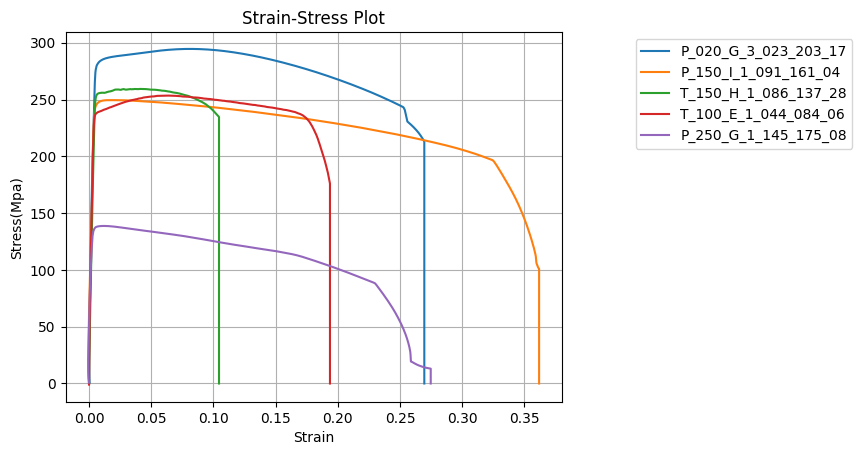

In [10]:
#Strain Stress plot for 5 example
exampleNames = []
for i in range(0, 5):
  randomnum = random.randint(0, len(csv_paths))
  exapmleStrain = data[randomnum].iloc[ : , 0]
  exapmleStress = data[randomnum].iloc[ : , 1]
  exampleName = file_names[randomnum].split(".")[0]
  exampleNames.append(exampleName)
  plt.plot(exapmleStrain, exapmleStress)


plt.xlabel('Strain')
plt.ylabel('Stress(Mpa)')
plt.legend(exampleNames,  bbox_to_anchor=(0.8, 0.5, 0.8, 0.5))
plt.title('Strain-Stress Plot')
plt.grid(True)
plt.show()

#Data analysis

In [11]:
#Check missing data
print(df.isnull().sum())

sample_type        0
temperature        0
lot                0
sample_id          0
yield_stress       0
ultimate_stress    0
fracture_strain    0
dtype: int64


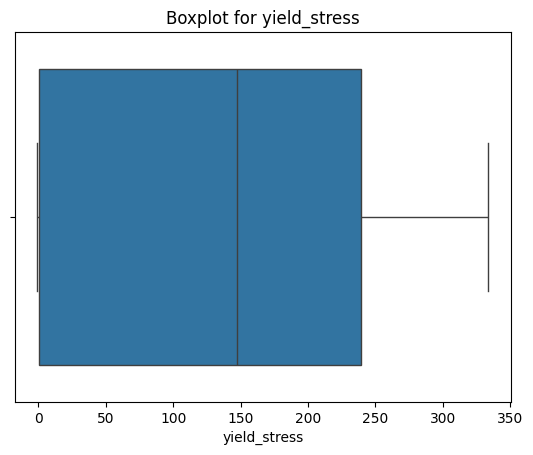

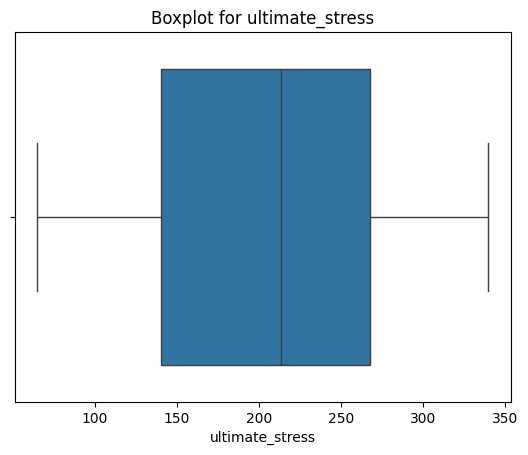

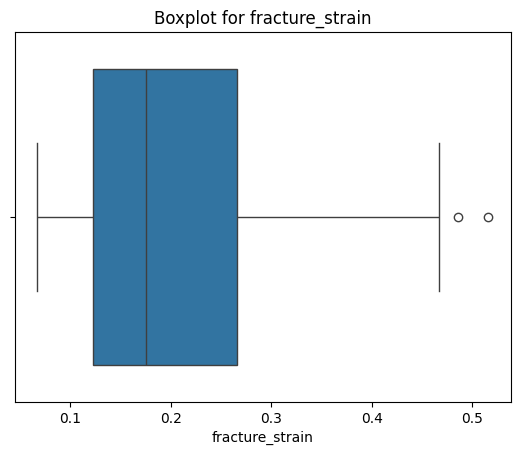

In [12]:
#Check outliers with histogram
features_to_check = ['yield_stress', 'ultimate_stress', 'fracture_strain']

for feature in features_to_check:
    plt.figure()
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot for {feature}')
    plt.show()


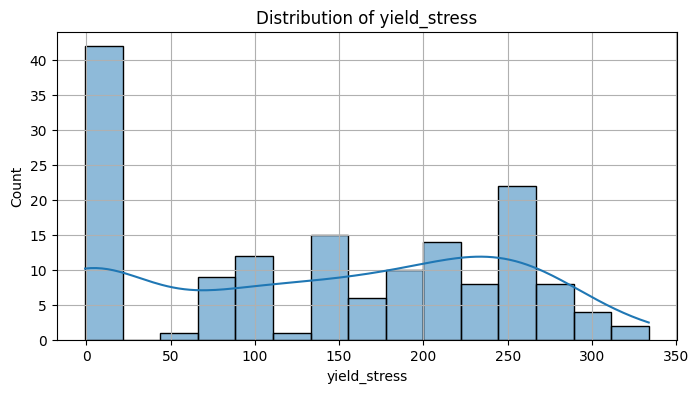

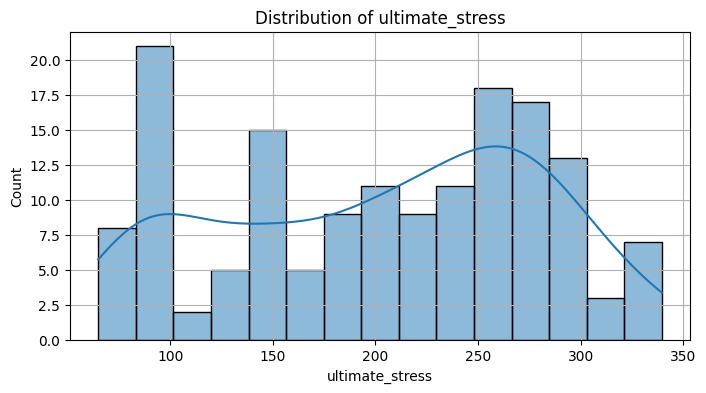

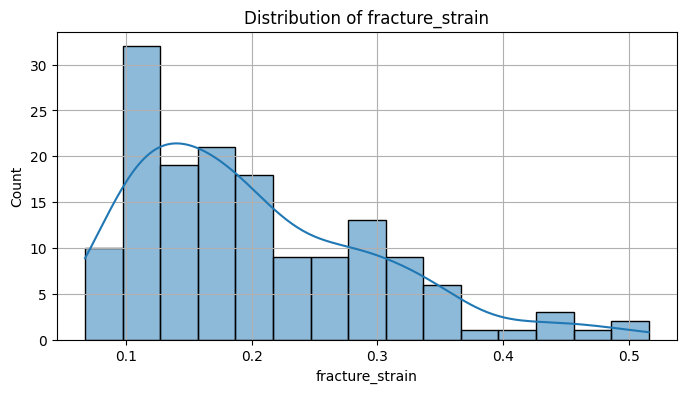

In [13]:
#show distribution of ultimate stress, yield stress, fracture strain
features = ['yield_stress', 'ultimate_stress', 'fracture_strain']
for i in features:
  plt.figure(figsize=(8,4))
  sns.histplot(df[i], bins=15, kde=True)
  plt.title(f'Distribution of {i}')
  plt.xlabel(f'{i}')
  plt.grid(True)

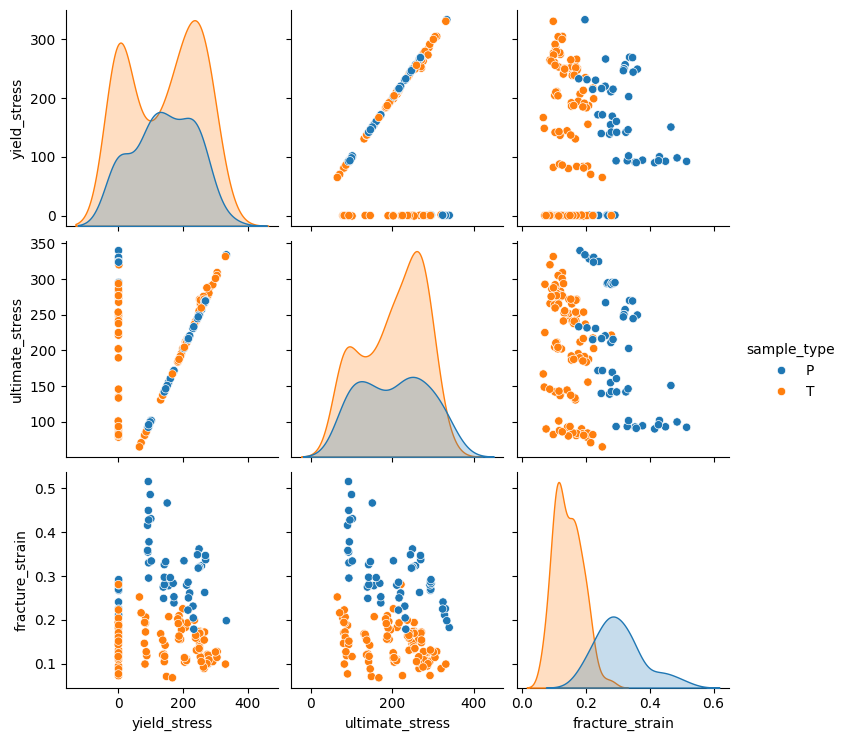

In [14]:
#Pair plot
sns.pairplot(df, hue='sample_type', diag_kind='kde')
plt.show()

In [15]:
#Convert text featutres to numeric features
##One-hot encoding for 'lot' and 'sample_type' column
df_encoded = pd.get_dummies(df, columns=['sample_type','lot'], drop_first=True)


# Convert True/False into 1/0
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

df_encoded.head()

,temperature,sample_id,yield_stress,ultimate_stress,fracture_strain,sample_type_T,lot_B,lot_C,lot_D,lot_E,lot_F,lot_G,lot_H,lot_I
0,020,2,0.909555,293.457419,0.267111,0,0,0,0,0,0,1,0,0
98,020,1,0.597087,282.622140,0.121390,1,0,0,1,0,0,0,0,0
21,020,1,0.692568,273.200296,0.109963,1,1,0,0,0,0,0,0,0
69,020,1,286.069758,289.881300,0.106461,1,0,0,0,0,0,0,0,1
133,020,3,0.374007,339.608209,0.182260,0,0,0,0,0,1,0,0,0


In [16]:
for i in features:
  correlation = df_encoded.corr(numeric_only=True)[i].sort_values(ascending=False)
  print(f"\n **Correlation with {i}** \n {correlation}")


 **Correlation with yield_stress** 
 yield_stress       1.000000
ultimate_stress    0.298605
lot_G              0.072214
lot_C              0.035226
lot_H              0.009973
sample_type_T      0.001569
lot_F             -0.000395
lot_I             -0.022575
lot_D             -0.035249
fracture_strain   -0.041504
lot_B             -0.065190
lot_E             -0.125126
Name: yield_stress, dtype: float64

 **Correlation with ultimate_stress** 
 ultimate_stress    1.000000
yield_stress       0.298605
lot_H              0.092817
lot_C              0.032451
lot_F              0.009628
lot_D              0.004747
lot_G             -0.004195
sample_type_T     -0.006007
lot_I             -0.014345
lot_E             -0.045856
lot_B             -0.047488
fracture_strain   -0.273835
Name: ultimate_stress, dtype: float64

 **Correlation with fracture_strain** 
 fracture_strain    1.000000
lot_I              0.275587
lot_G              0.161484
lot_F              0.141685
lot_H              0.11

# Data preprocessing for model

In [17]:
# select inputs(x) and outputs(y)
X = df_encoded.drop(['yield_stress', 'ultimate_stress', 'fracture_strain'], axis=1)
y = df_encoded[['yield_stress', 'ultimate_stress', 'fracture_strain']]

# split data to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Print split results
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (123, 11)
X_test shape: (31, 11)
y_train shape: (123, 3)
y_test shape: (31, 3)


In [18]:
#Normalization with MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# models Implementation

##RandomForestRegressor

In [19]:
#Create RandomForestRegressor model
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,random_state=42,max_depth=10))

#Train RandomForestRegressor model with train dataset
rf_model.fit(X_train_scaled, y_train)

#Test RandomForestRegressor model with test dataset
y_pred_rf = rf_model.predict(X_test_scaled)

#Evaluate model
mse_rf = mean_squared_error(y_test, y_pred_rf, multioutput='raw_values')
r2_rf = r2_score(y_test, y_pred_rf, multioutput='raw_values')

#Print evaluation results for each output
target_names = ['yield_stress', 'ultimate_stress', 'fracture_strain']
for i, name in enumerate(target_names):
    print(f"\n for {name} MSE : {mse_rf[i]:.2f} and R²: {r2_rf[i]:.2f}")


 for yield_stress MSE : 6942.70 and R²: 0.34

 for ultimate_stress MSE : 91.08 and R²: 0.98

 for fracture_strain MSE : 0.00 and R²: 0.76


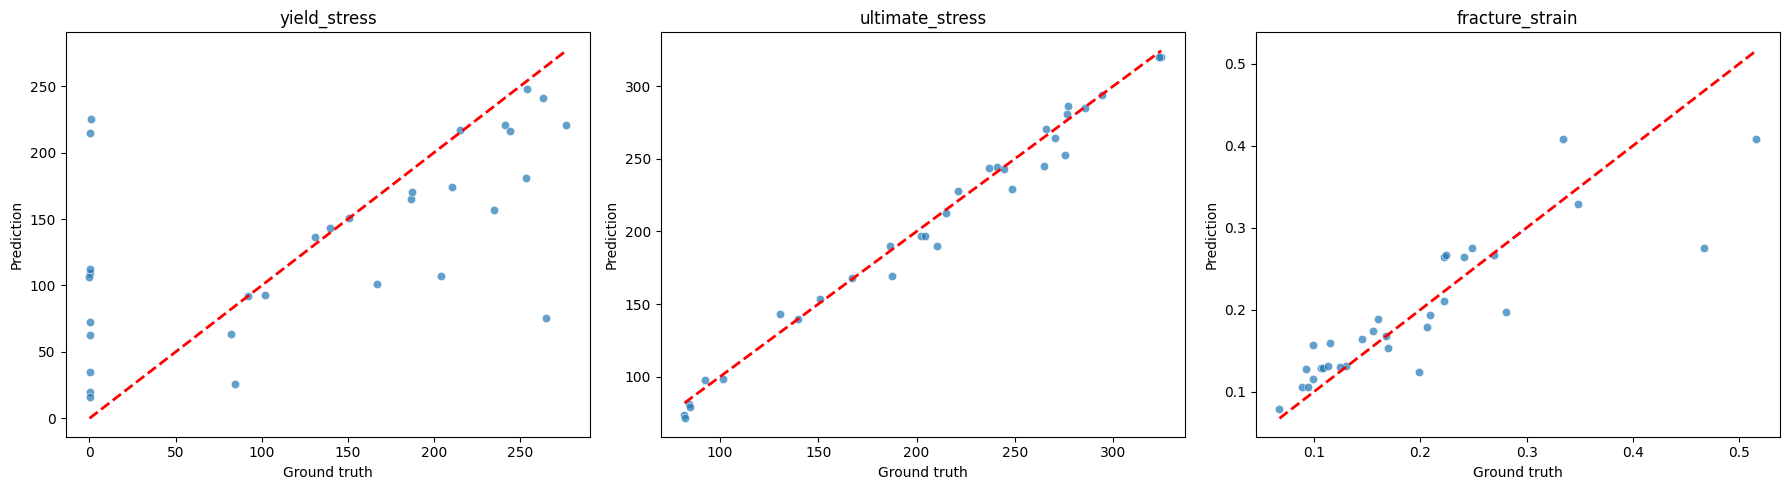

In [20]:
#Plot ground truth and prediction for each output
plt.figure(figsize=(18, 5))
for i, name in enumerate(target_names):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=y_test.iloc[:, i], y=y_pred_rf[:, i], alpha=0.7)
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
             [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
             'r--', linewidth=2)
    plt.xlabel("Ground truth")
    plt.ylabel("Prediction")
    plt.title(f"{name}")

plt.tight_layout()
plt.show()



##MLPRegressor

In [29]:
#Create model
mlp_model = MultiOutputRegressor(
    MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        learning_rate_init=0.01,
        max_iter=3000,
        batch_size=16,
        alpha=0.001,
        early_stopping=True,
        random_state=42
    )
)



#train model
mlp_model.fit(X_train_scaled, y_train)

#test model
y_pred_mlp = mlp_model.predict(X_test_scaled)


#Evaluate model
mse_mlp = mean_squared_error(y_test, y_pred_mlp, multioutput='raw_values')
r2_mlp = r2_score(y_test, y_pred_mlp, multioutput='raw_values')


#Print evaluation results for each output
for i, name in enumerate(target_names):
    print(f"\n for {name} MSE: {mse_mlp[i]:.2f} and R²: {r2_mlp[i]:.2f}")


 for yield_stress MSE: 10889.43 and R²: -0.03

 for ultimate_stress MSE: 534.38 and R²: 0.90

 for fracture_strain MSE: 0.00 and R²: 0.68


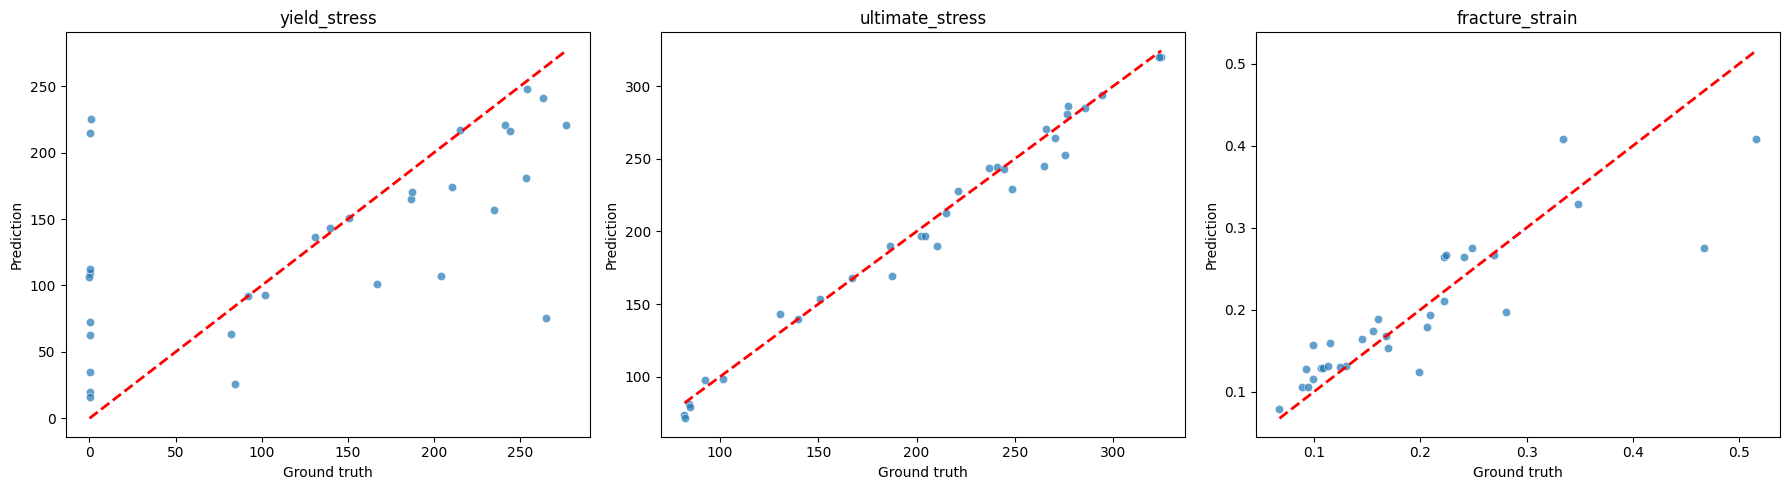

In [30]:
#Plot ground truth and prediction for each output
plt.figure(figsize=(18, 5))
for i, name in enumerate(target_names):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=y_test.iloc[:, i], y=y_pred_rf[:, i], alpha=0.7)
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
             [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
             'r--', linewidth=2)
    plt.xlabel("Ground truth")
    plt.ylabel("Prediction")
    plt.title(f"{name}")

plt.tight_layout()
plt.show()

